In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [7]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [9]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [12]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Donchian Channel Test

In [14]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
            ("use_activation", use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [16]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [18]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [20]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [22]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [24]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
    y_sum = y.rolling(r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
    y_sqr = (y**2).rolling(r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

    ## Calculate the R squared
    n = r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above 0.8 are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    return df

In [26]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    # z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
    #      slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())
    # Removing the Min Period, the Z-Score will be calculated when the mavg_z_score_window history is available
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).std())
    

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [28]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [30]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           use_activation=True, tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [32]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                use_activation=True, tanh_activation_constant_dict=None, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                       entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [34]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Donchian Channel Breakout Parameter Optimization

In [37]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 28
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-06-30'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.6
donchian_signal_weight = 0.4
use_activation = False
tanh_activation_constant_dict = None
lower_r_sqr_limit = 0.30
upper_r_sqr_limit = 0.90
r2_window = 80
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
use_specific_start_date = True
signal_start_date = pd.Timestamp('2021-06-01').date()

In [39]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2023-12-31
warm_up_days                  : 285
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.6

entry_rolling_donchian_window : 28
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.4

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6

lower_r_sqr_limit   

In [41]:
start_date

datetime.date(2022, 4, 1)

In [94]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian\n",
## Stop Loss = 2.0 * ATR
# ticker_list_test = ['BTC-USD']
df_donchian_only = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [96]:
df_donchian_only = calculate_asset_level_returns(df_donchian_only, end_date=end_date, ticker_list=ticker_list)

In [98]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
perf.calculate_risk_and_performance_metrics(df_donchian_only, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.17308015206816862,
 'annualized_sharpe_ratio': 0.47164752542280275,
 'calmar_ratio': 0.295034601117698,
 'annualized_std_dev': 0.4986929601724622,
 'max_drawdown': -0.5866435713386777,
 'max_drawdown_duration': Timedelta('560 days 00:00:00'),
 'hit_rate': 0.40523690773067333,
 't_statistic': 0.8645958329383346,
 'p_value': 0.38751950536750024,
 'trade_count': 1920.0}

In [100]:
df_donchian_only.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_20,BTC-USD_cash_shrink_factor,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_20,ETH-USD_cash_shrink_factor,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_20,SOL-USD_cash_shrink_factor,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_20,ADA-USD_cash_shrink_factor,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_20,AVAX-USD_cash_shrink_factor,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,BTC-USD_daily_pnl,BTC-USD_daily_pct_returns,BTC-USD_position_count,ETH-USD_daily_pnl,ETH-USD_daily_pct_returns,ETH-USD_position_count,SOL-USD_daily_pnl,SOL-USD_daily_pct_returns,SOL-USD_position_count,ADA-USD_daily_pnl,ADA-USD_daily_pct_returns,ADA-USD_position_count,AVAX-USD_daily_pnl,AVAX-USD_daily_pct_returns,A

In [102]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
daily_pct_return_cols = [f'{ticker}_daily_pct_returns' for ticker in ticker_list]

<Axes: xlabel='date'>

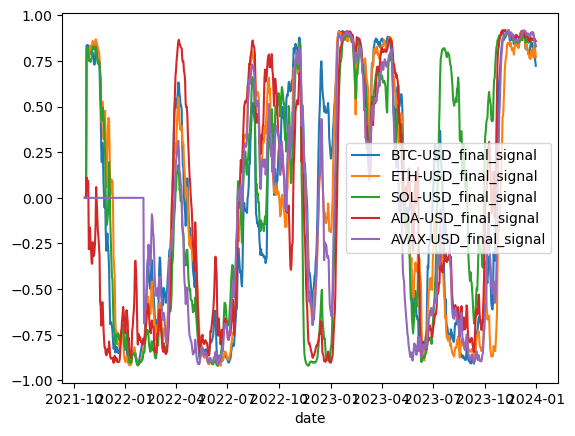

In [104]:
df_donchian_only[final_signal_cols].plot()

<Axes: xlabel='date'>

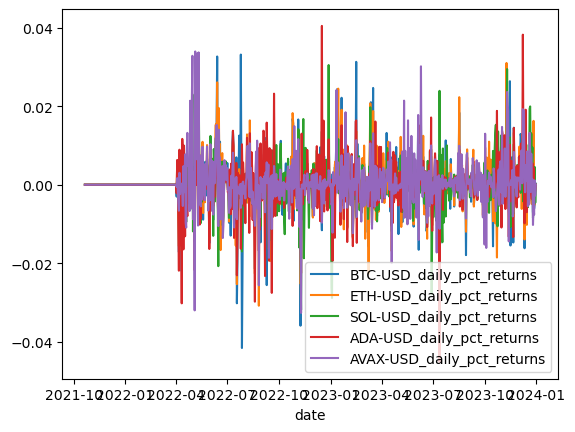

In [106]:
df_donchian_only[daily_pct_return_cols].plot()

<Axes: xlabel='date'>

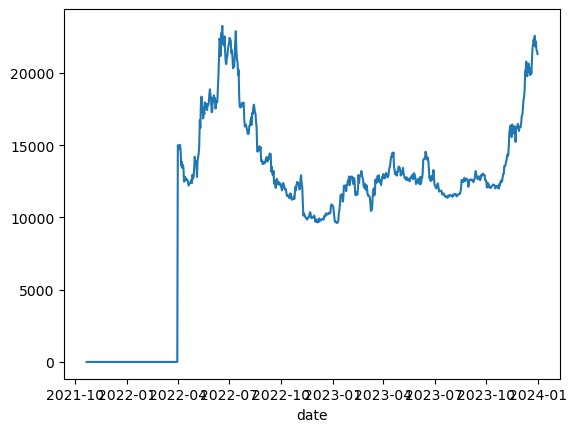

In [108]:
df_donchian_only['total_portfolio_value'].plot()

## Run-Walk Forward Analysis for Donchian Channels

In [43]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [10, 14, 20, 28, 40, 56],
        # "exit_window": [0.25, 0.5, 0.75, 1],
        # 'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [45]:
def run_walk_forward_donchian_ribbon(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date, ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_entry_window = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['entry_window'].iloc[0]
        print(f'Best In Sample Entry Window: {best_in_sample_entry_window}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=best_in_sample_entry_window, exit_rolling_donchian_window=exit_window, 
            use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)

        df_os = df_os[df_os.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

        ## In Sample Performance Metrics
        print('Getting In Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_is,
            'end_date': end_date_is,
            'entry_window': best_in_sample_entry_window,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [47]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-10-01').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    if end_date_os > last_available_date:
        print('end_date_os > last_available_date')
        end_date_os = last_available_date
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
    
    print("Run Dates: ")
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS s

In [49]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [136]:
%%time
df_performance_donchian_1 = run_walk_forward_donchian_ribbon(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [140]:
df_performance_donchian_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2024-04-01.pickle')

In [142]:
%%time
df_performance_donchian_2 = run_walk_forward_donchian_ribbon(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [144]:
df_performance_donchian_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-10-01-2024-10-01.pickle')

In [146]:
%%time
df_performance_donchian_3 = run_walk_forward_donchian_ribbon(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [147]:
df_performance_donchian_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2023-04-01-2025-04-01.pickle')

In [150]:
%%time
df_performance_donchian_4 = run_walk_forward_donchian_ribbon(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [151]:
df_performance_donchian_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2023-10-01-2025-10-01.pickle')

In [154]:
df_performance_donchian = pd.concat([df_performance_donchian_1, df_performance_donchian_2, df_performance_donchian_3, df_performance_donchian_4], axis=0, ignore_index=True)

In [158]:
df_performance_donchian.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2025-10-01.pickle')

## Analyze Walk Forward Results for Donchian Channels

In [ ]:
# strategy_cols = df_perf[sharpe_col].columns.tolist()

In [53]:
def plot_donchian_channel_performance(df_perf, ticker_list, sharpe_col='annualized_sharpe_ratio'):

    fig = plt.figure(figsize=(15,10))
    layout = (1,1)
    signal_ax = plt.subplot2grid(layout, (0,0))
    # price_ax = signal_ax.twinx()
    # equity_curve_ax = plt.subplot2grid(layout, (0,1))
    # sharpe_ax = plt.subplot2grid(layout, (1,0))
    # portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    for col in df_perf[sharpe_col].columns:
        _ = signal_ax.plot(df_perf.index, df_perf[sharpe_col][col], label=col, alpha=0.9)

    _ = signal_ax.set_title(f'Donchian Strategy Performance')
    _ = signal_ax.set_ylabel('Sharpe Ratio')
    _ = signal_ax.set_xlabel('Strategy')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.tick_params(axis='x', labelrotation=90)
    _ = signal_ax.grid()

    plt.tight_layout()

    fig = plt.figure(figsize=(20,15))
    layout = (2,2)
    fold_1_ax = plt.subplot2grid(layout, (0,0))
    fold_2_ax = plt.subplot2grid(layout, (0,1))
    fold_3_ax = plt.subplot2grid(layout, (1,0))
    fold_4_ax = plt.subplot2grid(layout, (1,1))

    strategy_cols = df_perf[sharpe_col].columns.tolist()
    
    for ticker in ticker_list:
        ticker_col = f'{ticker}_annualized_sharpe_ratio'
        _ = fold_1_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[0]], label=ticker, alpha=0.9)
        _ = fold_2_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[1]], label=ticker, alpha=0.9)
        _ = fold_3_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[2]], label=ticker, alpha=0.9)
        _ = fold_4_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[3]], label=ticker, alpha=0.9)

    _ = fold_1_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[0]}')
    _ = fold_1_ax.set_ylabel('Sharpe Ratio')
    _ = fold_1_ax.set_xlabel('Strategy')
    _ = fold_1_ax.legend(loc='upper left', ncols=3)
    _ = fold_1_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_1_ax.grid()

    _ = fold_2_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[1]}')
    _ = fold_2_ax.set_ylabel('Sharpe Ratio')
    _ = fold_2_ax.set_xlabel('Strategy')
    _ = fold_2_ax.legend(loc='upper left', ncols=3)
    _ = fold_2_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_2_ax.grid()

    _ = fold_3_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[2]}')
    _ = fold_3_ax.set_ylabel('Sharpe Ratio')
    _ = fold_3_ax.set_xlabel('Strategy')
    _ = fold_3_ax.legend(loc='upper left', ncols=3)
    _ = fold_3_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_3_ax.grid()

    _ = fold_4_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[3]}')
    _ = fold_4_ax.set_ylabel('Sharpe Ratio')
    _ = fold_4_ax.set_xlabel('Strategy')
    _ = fold_4_ax.legend(loc='upper left', ncols=3)
    _ = fold_4_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_4_ax.grid()

    plt.tight_layout()

    return

In [55]:
df_performance_donchian = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2025-10-01.pickle')

In [57]:
out_of_sample_cond = (df_performance_donchian['sampling_category'] == 'out_sample')
df_performance_donchian_os = df_performance_donchian[out_of_sample_cond]
df_performance_donchian_is = df_performance_donchian[~out_of_sample_cond]

In [59]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
df_performance_donchian_is.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
10                          1.252823  0.957475  0.812336          0.672941   
14                          1.250954  0.971353  0.718448          0.671312   
20                          1.233180  0.931848  0.721452          0.658009   
28                          1.195184  0.893429  0.666712          0.629803   
40                          1.242642  0.936693  0.688921          0.668032   
56                          1.244409  0.924160  0.766121          0.670977   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
10            0.552325  0.514787    -0.293417 -0.347717  0.170922   
14            0.545274  0.458344    -0.296009 -0.347527  0.164812   
20            0.513965  0.443851    -0.298718 -0.352725  0.165888   
28            0.476911  0.402329    -0.300968 -0.353111  0.165827   
40            0.510713  0.424946    -0.291610 -0.351675  0.162659   
56            0.515159  0.471848    -0.293228 -0.355586  0.165382   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.452902  0.501482  0.574258   
14                                  0.384959  0.429228  0.572986   
20                                  0.299556  0.350163  0.585677   
28                                  0.072552  0.191244  0.541916   
40                                  0.058653  0.168711  0.567829   
56                                  0.072891  0.177773  0.579519   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.568042  0.463805  0.590903   
14                                  0.396565  0.395435  0.501300   
20                                  0.262464  0.278879  0.431202   
28                                  0.269183  0.366845  0.380954   
40                                  0.504937  0.439102  0.450914   
56                                  0.640985  0.528232  0.545706   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.268856  0.067038  0.456488   
14                                  0.303210  0.137320  0.430358   
20                                  0.373493  0.154560  0.539295   
28                                  0.358403  0.117924  0.588379   
40                                  0.178255  0.062698  0.493870   
56                                  0.100148 -0.050045  0.551886   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.687183  0.296410  1.085071   
14                                  0.779230  0.405000  1.049100   
20                                  0.759948  0.405500  1.037998   
28                                  0.595538  0.274150  0.960808   
40                                  0.617103  0.280336  0.905117   
56                                  0.658196  0.306536  0.927952   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                              

In [61]:
df_performance_donchian_os.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                    annualized_return  \
                              median      mean      std            median   
entry_window                                                                
10                         -0.445712 -0.445712  2.58356          0.106397   
40                          2.603239  2.603239      NaN          2.420425   
56                          0.065850  0.065850      NaN         -0.036367   

                                 max_drawdown                     \
                  mean       std       median      mean      std   
entry_window                                                       
10            0.106397  1.096412    -0.317497 -0.317497  0.05662   
40            2.420425       NaN    -0.221524 -0.221524      NaN   
56           -0.036367       NaN    -0.203298 -0.203298      NaN   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.117844 -0.117844  1.882238   
40                                  0.700044  0.700044       NaN   
56                                 -1.229670 -1.229670       NaN   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.795006 -0.795006  1.120239   
40                                  1.504468  1.504468       NaN   
56                                 -0.657546 -0.657546       NaN   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -2.069682 -2.069682  1.996286   
40                                  2.909615  2.909615       NaN   
56                                 -1.475761 -1.475761       NaN   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.234943 -0.234943  1.211666   
40                                  1.973438  1.973438       NaN   
56                                  1.163847  1.163847       NaN   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                                  -0.967414 -0.967414  3.986596  
40                                   2.203500  2.203500       NaN  
56                                   0.556059  0.556059       NaN

In [63]:
df_performance_donchian_os.groupby(['entry_window','start_date']).agg(agg_dict)

annualized_sharpe_ratio                \
                                         median      mean std   
entry_window start_date                                         
10           2023-04-01                1.381141  1.381141 NaN   
             2023-10-01               -2.272565 -2.272565 NaN   
40           2022-04-01                2.603239  2.603239 NaN   
56           2022-10-01                0.065850  0.065850 NaN   

                        annualized_return               max_drawdown  \
                                   median      mean std       median   
entry_window start_date                                                
10           2023-04-01          0.881678  0.881678 NaN    -0.277461   
             2023-10-01         -0.668883 -0.668883 NaN    -0.357534   
40           2022-04-01          2.420425  2.420425 NaN    -0.221524   
56           2022-10-01         -0.036367 -0.036367 NaN    -0.203298   

                                      BTC-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.277461 NaN                        1.213100   
             2023-10-01 -0.357534 NaN                       -1.448787   
40           2022-04-01 -0.221524 NaN                        0.700044   
56           2022-10-01 -0.203298 NaN                       -1.229670   

                                      ETH-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01  1.213100 NaN                       -0.002877   
             2023-10-01 -1.448787 NaN                       -1.587134   
40           2022-04-01  0.700044 NaN                        1.504468   
56           2022-10-01 -1.229670 NaN                       -0.657546   

                                      SOL-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.002877 NaN                       -0.658095   
             2023-10-01 -1.587134 NaN                       -3.481270   
40           2022-04-01  1.504468 NaN                        2.909615   
56           2022-10-01 -0.657546 NaN                       -1.475761   

                                      ADA-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.658095 NaN                        0.621835   
             2023-10-01 -3.481270 NaN                       -1.091720   
40           2022-04-01  2.909615 NaN                        1.973438   
56           2022-10-01 -1.475761 NaN                        1.163847   

                                      AVAX-USD_annualized_sharpe_ratio  \
                             mean std                           median   
entry_window start_date                                                  
10           2023-04-01  0.621835 NaN                         1.851535   
             2023-10-01 -1.091720 NaN                        -3.786363   
40           2022-04-01  1.973438 NaN                         2.203500   
56           2022-10-01  1.163847 NaN                         0.556059   

                                       
                             mean std  
entry_window start_date                
10           2023-04-01  1.851535 NaN  
             2023-10-01 -3.786363 NaN  
40           2022-04-01  2.203500 NaN  
56           2022-10-01  0.556059 NaN

In [65]:
df_performance_donchian_os.groupby(['start_date','end_date','entry_window']).agg(agg_dict)

annualized_sharpe_ratio                \
                                                    median      mean std   
start_date end_date   entry_window                                         
2022-04-01 2023-09-30 40                          2.603239  2.603239 NaN   
2022-10-01 2024-03-31 56                          0.065850  0.065850 NaN   
2023-04-01 2024-09-30 10                          1.381141  1.381141 NaN   
2023-10-01 2025-03-31 10                         -2.272565 -2.272565 NaN   

                                   annualized_return                \
                                              median      mean std   
start_date end_date   entry_window                                   
2022-04-01 2023-09-30 40                    2.420425  2.420425 NaN   
2022-10-01 2024-03-31 56                   -0.036367 -0.036367 NaN   
2023-04-01 2024-09-30 10                    0.881678  0.881678 NaN   
2023-10-01 2025-03-31 10                   -0.668883 -0.668883 NaN   

                                   max_drawdown                \
                                         median      mean std   
start_date end_date   entry_window                              
2022-04-01 2023-09-30 40              -0.221524 -0.221524 NaN   
2022-10-01 2024-03-31 56              -0.203298 -0.203298 NaN   
2023-04-01 2024-09-30 10              -0.277461 -0.277461 NaN   
2023-10-01 2025-03-31 10              -0.357534 -0.357534 NaN   

                                   BTC-USD_annualized_sharpe_ratio            \
                                                            median      mean   
start_date end_date   entry_window                                             
2022-04-01 2023-09-30 40                                  0.700044  0.700044   
2022-10-01 2024-03-31 56                                 -1.229670 -1.229670   
2023-04-01 2024-09-30 10                                  1.213100  1.213100   
2023-10-01 2025-03-31 10                                 -1.448787 -1.448787   

                                       ETH-USD_annualized_sharpe_ratio  \
                                   std                          median   
start_date end_date   entry_window                                       
2022-04-01 2023-09-30 40           NaN                        1.504468   
2022-10-01 2024-03-31 56           NaN                       -0.657546   
2023-04-01 2024-09-30 10           NaN                       -0.002877   
2023-10-01 2025-03-31 10           NaN                       -1.587134   

                                                  \
                                        mean std   
start_date end_date   entry_window                 
2022-04-01 2023-09-30 40            1.504468 NaN   
2022-10-01 2024-03-31 56           -0.657546 NaN   
2023-04-01 2024-09-30 10           -0.002877 NaN   
2023-10-01 2025-03-31 10           -1.587134 NaN   

                                   SOL-USD_annualized_sharpe_ratio            \
                                                            median      mean   
start_date end_date   entry_window                                             
2022-04-01 2023-09-30 40                                  2.909615  2.909615   
2022-10-01 2024-03-31 56                                 -1.475761 -1.475761   
2023-04-01 2024-09-30 10                                 -0.658095 -0.658095   
2023-10-01 2025-03-31 10                                 -3.481270 -3.481270   

                                       ADA-USD_annualized_sharpe_ratio  \
                                   std                          median   
start_date end_date   entry_window                                       
2022-04-01 2023-09-30 40           NaN                        1.973438   
2022-10-01 2024-03-31 56           NaN                        1.163847   
2023-04-01 2024-09-30 10           NaN                        0.621835   
2023-10-01 2025-03-31 10           NaN                       -1.091720   

                              

In [67]:
df_performance_donchian

,sampling_category,start_date,end_date,entry_window,exit_window,exit_gate,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,ADA-USD_annualized_return,AVAX-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,AVAX-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,ADA-USD_annualized_std_dev,AVAX-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,ADA-USD_max_drawdown,AVAX-USD_max_drawdown
0,in_sample,2022-04-01,2023-09-30,10,28,False,-0.175161,-0.240724,-0.294243,0.500630,-0.595294,468 days,0.485401,-0.174126,0.861831,1808.0,0.032229,0.000547,-0.036666,-0.124077,0.154697,-0.075334,-0.344205,-0.615480,-1.273877,0.725887,0.126159,0.121226,0.127730,0.136740,0.146381,-0.145185,-0.152960,-0.200970,-0.213672,-0.172749
1,in_sample,2022-04-01,2023-09-30,14,28,False,-0.111736,-0.092657,-0.191499,0.500158,-0.583478,468 days,0.483577,0.007562,0.993970,1755.0,0.022619,0.016451,-0.020744,-0.102139,0.159173,-0.143300,-0.215316,-0.495433,-1.112647,0.755438,0.129535,0.120096,0.125869,0.134735,0.145657,-0.154645,-0.141720,-0.182344,-0.193547,-0.174328
2,in_sample,2022-04-01,2023-09-30,20,28,False,-0.133842,-0.143245,-0.226071,0.500423,-0.592036,468 days,0.483577,-0.054483,0.956570,1706.0,0.010845,0.014633,-0.039226,-0.097737,0.141249,-0.231537,-0.229073,-0.635190,-1.075393,0.659306,0.130439,0.120576,0.127943,0.134774,0.142415,-0.160530,-0.143008,-0.203589,-0.179652,-0.190193
3,in_sample,2022-04-01,2023-09-30,28,28,False,-0.117767,-0.103282,-0.199837,0.503827,-0.589315,468 days,0.483577,-0.006082,0.995149,1676.0,0.008738,0.045179,-0.051844,-0.101056,0.134121,-0.237644,0.020181,-0.750708,-1.098508,0.635589,0.134027,0.120062,0.126259,0.135283,0.136541,-0.175527,-0.133559,-0.214372,-0.178959,-0.187743
4,in_sample,2022-04-01,2023-09-30,40,28,False,-0.111868,-0.088153,-0.190202,0.501558,-0.588152,468 days,0.470803,0.012095,0.990354,1615.0,0.011775,0.021999,-0.036892,-0.101387,0.119276,-0.217721,-0.166068,-0.620572,-1.041604,0.543528,0.132936,0.121459,0.127182,0.142135,0.134836,-0.174548,-0.158817,-0.181342,-0.183932,-0.180180
5,in_sample,2022-04-01,2023-09-30,56,28,False,-0.168686,-0.211598,-0.282452,0.518130,-0.597220,468 days,0.474453,-0.140638,0.888207,1564.0,0.006439,0.014739,-0.064864,-0.100384,0.089251,-0.249661,-0.224817,-0.832427,-1.051311,0.337355,0.135865,0.121768,0.130002,0.139633,0.136957,-0.181131,-0.160058,-0.204256,-0.198328,-0.171203
6,out_sample,2022-04-01,2023-09-30,40,28,False,2.420425,2.603239,10.926252,0.509662,-0.221524,69 days,0.530055,1.912036,0.057442,561.0,0.152081,0.313855,0.493395,0.343043,0.359030,0.700044,1.504468,2.909615,1.973438,2.203500,0.151042,0.158962,0.124081,0.129307,0.121713,-0.103596,-0.075055,-0.047995,-0.067383,-0.054056
7,in_sample,2022-10-01,2024-03-31,10,28,False,0.683936,1.268078,2.537095,0.458211,-0.269575,205 days,0.505474,1.685606,0.092442,1757.0,0.208044,0.187834,0.078258,0.096717,0.176998,1.175456,1.063341,0.275085,0.423723,1.073803,0.127564,0.124606,0.125650,0.120637,0.113233,-0.075923,-0.079012,-0.124513,-0.093834,-0.088098
8,in_sample,2022-10-01,2024-03-31,14,28,False,0.708945,1.301933,2.744428,0.457333,-0.258322,205 days,0.498175,1.727283,0.084681,1660.0,0.195929,0.179374,0.099711,0.110026,0.159991,1.090293,1.003927,0.438294,0.527404,0.947102,0.128249,0.124799,0.123474,0.120160,0.112816,-0.082194,-0.082501,-0.099827,-0.086327,-0.080670
9,in_sample,2022-10-01,2024-03-31,20,28,False,0.673241,1.253906,2.536225,0.459202,-0.265450,204 days,0.503650,1.668196,0.095849,1653.0,0.187783,0.154658,0.108071,0.100238,0.154802,1.033076,0.819659,0.494166,0.450087,0.889643,0.128709,0.127036,0.125444,0.121198,0.115336,-0.086681,-0.083345,-0.111156,-0.09

## Re-Run Walk Forward for every Window In and Out of Sample to Create an Ensemble

In [69]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [10, 14, 20, 28, 40, 56],
        # "exit_window": [0.25, 0.5, 0.75, 1],
        # 'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [71]:
def run_walk_forward_donchian_ribbon_all(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date, ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            ## Out of Sample Dataframe
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
    
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)
    
            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [73]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-10-01').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    if end_date_os > last_available_date:
        print('end_date_os > last_available_date')
        end_date_os = last_available_date
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
    
    print("Run Dates: ")
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS s

In [199]:
%%time
df_performance_donchian_all_1 = run_walk_forward_donchian_ribbon_all(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [200]:
df_performance_donchian_all_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2024-04-01.pickle')

In [201]:
%%time
df_performance_donchian_all_2 = run_walk_forward_donchian_ribbon_all(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [202]:
df_performance_donchian_all_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-10-01-2024-10-01.pickle')

In [203]:
%%time
df_performance_donchian_all_3 = run_walk_forward_donchian_ribbon_all(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [204]:
df_performance_donchian_all_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-04-01-2025-04-01.pickle')

In [205]:
%%time
df_performance_donchian_all_4 = run_walk_forward_donchian_ribbon_all(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calcula

In [149]:
df_performance_donchian_all_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-10-01-2025-10-01.pickle')

In [75]:
df_performance_donchian_all_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2024-04-01.pickle')
df_performance_donchian_all_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-10-01-2024-10-01.pickle')
df_performance_donchian_all_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-04-01-2025-04-01.pickle')
df_performance_donchian_all_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-10-01-2025-10-01.pickle')

In [93]:
df_performance_donchian_all = pd.concat([df_performance_donchian_all_1,df_performance_donchian_all_2,df_performance_donchian_all_3,df_performance_donchian_all_4], axis=0, ignore_index=True)

In [95]:
df_performance_donchian_all.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2025-10-01.pickle')

In [141]:
df_performance_donchian_all_is = df_performance_donchian_all[df_performance_donchian_all.sampling_category == 'in_sample']
df_performance_donchian_all_os = df_performance_donchian_all[df_performance_donchian_all.sampling_category == 'out_sample']

In [163]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
df_performance_donchian_all.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
10                          1.252823  0.782109  1.593527          0.672941   
14                          1.250954  0.792581  1.474341          0.671312   
20                          1.210006  0.757998  1.403480          0.658009   
28                          1.169966  0.801417  1.117901          0.629803   
40                          1.162193  0.818928  1.132217          0.634518   
56                          1.244409  0.850102  1.097930          0.670977   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
10            0.742290  1.260399    -0.273518 -0.300313  0.134381   
14            0.699251  1.145106    -0.275798 -0.301015  0.128959   
20            0.636705  1.046472    -0.273450 -0.303504  0.126495   
28            0.572734  0.859634    -0.257695 -0.299302  0.126074   
40            0.589063  0.869743    -0.256195 -0.301160  0.123860   
56            0.606110  0.841853    -0.252952 -0.298623  0.126388   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.452902  0.291492  1.196489   
14                                  0.384959  0.285563  1.097809   
20                                  0.299556  0.229750  1.061641   
28                                  0.072552  0.153617  0.809737   
40                                  0.058653  0.086538  0.834858   
56                                  0.072891  0.123636  0.828912   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.241585  0.213968  1.171787   
14                                  0.091136  0.139338  1.068254   
20                                  0.012979  0.050211  0.855925   
28                                  0.127460  0.157743  0.712922   
40                                  0.276515  0.173990  0.908037   
56                                  0.498989  0.269384  0.970571   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.176426 -0.277993  1.653742   
14                                 -0.130797 -0.251228  1.648337   
20                                 -0.191185 -0.082270  1.451871   
28                                 -0.243713  0.061547  1.318982   
40                                 -0.286075 -0.073698  1.407017   
56                                 -0.421116 -0.116543  1.445299   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.786239  0.523077  1.194273   
14                                  0.957751  0.646766  1.130853   
20                                  0.995026  0.667532  1.107238   
28                                  0.887155  0.528539  1.015003   
40                                  0.617103  0.491138  0.956785   
56                                  0.664430  0.491744  0.937873   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                              

In [155]:
df_performance_donchian_all_is.groupby(['entry_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
14                          1.250954  0.971353  0.718448          0.671312   
10                          1.252823  0.957475  0.812336          0.672941   
40                          1.242642  0.936693  0.688921          0.668032   
20                          1.233180  0.931848  0.721452          0.658009   
56                          1.244409  0.924160  0.766121          0.670977   
28                          1.195184  0.893429  0.666712          0.629803   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
14            0.545274  0.458344    -0.296009 -0.347527  0.164812   
10            0.552325  0.514787    -0.293417 -0.347717  0.170922   
40            0.510713  0.424946    -0.291610 -0.351675  0.162659   
20            0.513965  0.443851    -0.298718 -0.352725  0.165888   
56            0.515159  0.471848    -0.293228 -0.355586  0.165382   
28            0.476911  0.402329    -0.300968 -0.353111  0.165827   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.384959  0.429228  0.572986   
10                                  0.452902  0.501482  0.574258   
40                                  0.058653  0.168711  0.567829   
20                                  0.299556  0.350163  0.585677   
56                                  0.072891  0.177773  0.579519   
28                                  0.072552  0.191244  0.541916   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.396565  0.395435  0.501300   
10                                  0.568042  0.463805  0.590903   
40                                  0.504937  0.439102  0.450914   
20                                  0.262464  0.278879  0.431202   
56                                  0.640985  0.528232  0.545706   
28                                  0.269183  0.366845  0.380954   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.303210  0.137320  0.430358   
10                                  0.268856  0.067038  0.456488   
40                                  0.178255  0.062698  0.493870   
20                                  0.373493  0.154560  0.539295   
56                                  0.100148 -0.050045  0.551886   
28                                  0.358403  0.117924  0.588379   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.779230  0.405000  1.049100   
10                                  0.687183  0.296410  1.085071   
40                                  0.617103  0.280336  0.905117   
20                                  0.759948  0.405500  1.037998   
56                                  0.658196  0.306536  0.927952   
28                                  0.595538  0.274150  0.960808   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
14                              

In [153]:
df_performance_donchian_all_os.groupby(['entry_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
56                          0.732911  0.776045  1.486994          0.426187   
28                          0.673337  0.709404  1.564893          0.346673   
40                          0.656912  0.701163  1.574655          0.335189   
14                          0.758556  0.613809  2.114362          0.426320   
10                          0.774836  0.606743  2.276664          0.446236   
20                          0.704453  0.584148  1.998752          0.366617   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
56            0.697060  1.187002    -0.237600 -0.241659  0.035617   
28            0.668557  1.240126    -0.236759 -0.245493  0.043217   
40            0.667413  1.252241    -0.239524 -0.250645  0.050334   
14            0.853227  1.669229    -0.249806 -0.254502  0.076630   
10            0.932256  1.829074    -0.243473 -0.252910  0.083242   
20            0.759446  1.522519    -0.245724 -0.254283  0.057934   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                  0.071048  0.069500  1.122304   
28                                  0.299533  0.115991  1.110160   
40                                  0.095981  0.004366  1.133962   
14                                  0.042679  0.141898  1.558443   
10                                 -0.041794  0.081503  1.700884   
20                                  0.011193  0.109337  1.499392   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                 -0.097159  0.010535  1.312079   
28                                 -0.341775 -0.051360  0.961359   
40                                 -0.220902 -0.091123  1.238208   
14                                 -0.499775 -0.116760  1.495502   
10                                 -0.390193 -0.035869  1.639588   
20                                 -0.526291 -0.178456  1.176455   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                 -1.132974 -0.183041  2.134878   
28                                 -0.883117  0.005170  1.924750   
40                                 -1.242423 -0.210094  2.079850   
14                                 -0.917896 -0.639776  2.398313   
10                                 -0.724238 -0.623024  2.419816   
20                                 -1.023703 -0.319100  2.116151   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                  0.827953  0.676953  1.048737   
28                                  0.960400  0.782928  1.143744   
40                                  0.729338  0.701941  1.094661   
14                                  1.000924  0.888531  1.314327   
10                                  0.883540  0.749744  1.419019   
20                                  1.122216  0.929564  1.264941   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
56                              

In [161]:
df_performance_donchian_all_os#.groupby(['start_date'])[['start_date','annualized_sharpe_ratio']]#.mean()#.sort_values('entry_window').reset_index(drop=True)

,sampling_category,start_date,end_date,entry_window,exit_window,exit_gate,annualized_return,annualized_sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,ADA-USD_annualized_return,AVAX-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,AVAX-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,ADA-USD_annualized_std_dev,AVAX-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,ADA-USD_max_drawdown,AVAX-USD_max_drawdown
1,out_sample,2022-04-01,2023-09-30,10,28,False,3.505433,3.149864,20.970496,0.506589,-0.167160,54 days,0.551913,2.298984,0.022642,601.0,0.369126,0.467410,0.447672,0.402191,0.395763,1.858386,2.224044,2.437648,2.323616,2.436757,0.151681,0.157717,0.137048,0.128379,0.121102,-0.046481,-0.073287,-0.050017,-0.047711,-0.057487
3,out_sample,2022-04-01,2023-09-30,14,28,False,3.190738,2.986645,18.099947,0.517073,-0.176284,63 days,0.546448,2.182901,0.030323,575.0,0.341703,0.415226,0.459383,0.408526,0.338866,1.723433,1.978847,2.547798,2.373747,2.081045,0.151578,0.158837,0.134166,0.127530,0.121602,-0.057254,-0.073973,-0.048138,-0.048186,-0.057190
5,out_sample,2022-04-01,2023-09-30,20,28,False,2.899687,2.853497,14.302012,0.509779,-0.202747,64 days,0.535519,2.088898,0.038108,579.0,0.338126,0.315401,0.491486,0.381053,0.323812,1.691180,1.478154,2.773557,2.248563,1.978714,0.152981,0.163033,0.129973,0.125740,0.122144,-0.064361,-0.075128,-0.041975,-0.059395,-0.058567
7,out_sample,2022-04-01,2023-09-30,28,28,False,2.398929,2.591592,11.150379,0.509619,-0.215143,69 days,0.524590,1.903820,0.058512,580.0,0.202408,0.276769,0.501068,0.338088,0.356694,0.973599,1.296602,2.886035,1.982611,2.183972,0.153814,0.162548,0.127002,0.126669,0.122021,-0.092700,-0.075647,-0.039741,-0.064830,-0.054072
9,out_sample,2022-04-01,2023-09-30,40,28,False,2.420425,2.603239,10.926252,0.509662,-0.221524,69 days,0.530055,1.912036,0.057442,561.0,0.152081,0.313855,0.493395,0.343043,0.359030,0.700044,1.504468,2.909615,1.973438,2.203500,0.151042,0.158962,0.124081,0.129307,0.121713,-0.103596,-0.075055,-0.047995,-0.067383,-0.054056
11,out_sample,2022-04-01,2023-09-30,56,28,False,2.291851,2.512706,9.998852,0.511410,-0.229211,72 days,0.535519,1.847450,0.066305,552.0,0.122490,0.334718,0.505124,0.305637,0.340266,0.524393,1.616595,3.009543,1.747159,2.082236,0.151020,0.157670,0.122505,0.129875,0.122070,-0.112735,-0.073854,-0.043554,-0.073093,-0.061413
13,out_sample,2022-10-01,2024-03-31,10,28,False,0.010795,0.168531,0.051530,0.493711,-0.209485,61 days,0.540984,0.189746,0.849719,559.0,-0.103407,-0.063863,-0.057738,0.199963,0.116443,-1.296688,-0.777509,-0.790381,1.145246,0.528075,0.117867,0.137270,0.127186,0.123508,0.134339,-0.066616,-0.077927,-0.066221,-0.042751,-0.058544
15,out_sample,2022-10-01,2024-03-31,14,28,False,0.020640,0.187889,0.100030,0.493594,-0.206339,61 days,0.551913,0.203527,0.838951,545.0,-0.089786,-0.077575,-0.061518,0.196197,0.126876,-1.151543,-0.858132,-0.827115,1.117403,0.601715,0.119339,0.141120,0.126512,0.123789,0.133304,-0.062115,-0.083123,-0.070950,-0.042106,-0.054330
17,out_sample,2022-10-01,2024-03-31,20,28,False,0.027473,0.201349,0.130826,0.495364,-0.209997,61 days,0.546448,0.213095,0.831491,531.0,-0.101308,-0.082583,-0.065669,0.229919,0.122081,-1.276220,-0.874424,-0.877376,1.324190,0.564469,0.117899,0.144254,0.124602,0.125699,0.134814,-0.063542,-0.091036,-0.069155,-0.042761,-0.057851
19,out_sample,2022-10-01,2024-03-31,28,28,False,0.006365,0.160921,0.030670,0.502393,-0.207518,55 days,0.540984,0.184024,0.854199,495.0,-0.096881,-0.074218,-0.056369,0.185747,0.121729,-1.219482,-0.818494,-0.790811,1.012175,0.561705,0.119189,0.143111,0.125539,0.128541,0.134919,-0.063310,-0.092680,-0.060058,-0.044765,-0.055021


## Test Ensemble Donchian Signal

In [ ]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [190]:
# Pull Close Prices from Coinbase
ticker = 'BTC-USD'
date_list = cn.coinbase_start_date_by_ticker_dict
if use_saved_files:
    file_end_date = pd.Timestamp(saved_file_end_date).date()
    filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
    output_file = f'coinbase_historical_price_folder/{filename}'
    df = pd.read_pickle(output_file)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
    df = df[date_cond]
else:
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
    df = df[date_cond]

# Create Column Names
donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
trend_binary_signal_col = f'{ticker}_trend_signal'
trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
final_binary_signal_col = f'{ticker}_final_binary_signal'
final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
final_signal_col = f'{ticker}_final_signal'

## Generate Trend Signal in Log Space
# df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)

## Generate Donchian Channels
# Donchian Buy signal: Price crosses above upper band
# Donchian Sell signal: Price crosses below lower band
donchian_ensemble_windows = [28, 40, 56]
donchian_dfs = []
for entry_window in donchian_ensemble_windows:
    
    df_ensemble = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_ensemble[t_1_close_col] = df_ensemble[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_{entry_window}_rank'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_ensemble[f'{col}_t_2'] = df_ensemble[col].shift(1)

    # Donchian Continuous Signal
    df_ensemble[donchian_continuous_signal_col] = ((df_ensemble[t_1_close_col] - df_ensemble[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_ensemble[f'{donchian_entry_upper_band_col}_t_2'] - df_ensemble[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_ensemble[donchian_continuous_signal_rank_col] = pct_rank(df_ensemble[donchian_continuous_signal_col]) - 0.5
    donchian_ensemble_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                              donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    donchian_dfs.append(df_ensemble[donchian_ensemble_cols])

df_donchian = pd.concat(donchian_dfs, axis=0)
df_donchian = pd.merge(df_donchian, df_ensemble[[donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col, t_1_close_col]],
                       left_index=True, right_index=True, how='left')

In [192]:
df_donchian.head()

,BTC-USD_28_donchian_entry_upper_band_price_t_2,BTC-USD_28_donchian_entry_lower_band_price_t_2,BTC-USD_28_donchian_entry_middle_band_price_t_2,BTC-USD_donchian_continuous_signal,BTC-USD_donchian_continuous_signal_28_rank,BTC-USD_40_donchian_entry_upper_band_price_t_2,BTC-USD_40_donchian_entry_lower_band_price_t_2,BTC-USD_40_donchian_entry_middle_band_price_t_2,BTC-USD_donchian_continuous_signal_40_rank,BTC-USD_56_donchian_entry_upper_band_price_t_2,BTC-USD_56_donchian_entry_lower_band_price_t_2,BTC-USD_56_donchian_entry_middle_band_price_t_2,BTC-USD_donchian_continuous_signal_56_rank,BTC-USD_28_donchian_exit_upper_band_price,BTC-USD_28_donchian_exit_lower_band_price,BTC-USD_28_donchian_exit_middle_band_price,t_1_close
date,,,,,,,,,,,,,,,,,
2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46296.34
2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45826.27
2022-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46422.16
2022-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46596.83


In [180]:
df_ensemble[donchian_ensemble_cols].head(100)

,BTC-USD_56_donchian_entry_upper_band_price_t_2,BTC-USD_56_donchian_entry_lower_band_price_t_2,BTC-USD_56_donchian_entry_middle_band_price_t_2,BTC-USD_28_donchian_exit_upper_band_price_t_2,BTC-USD_28_donchian_exit_lower_band_price_t_2,BTC-USD_28_donchian_exit_middle_band_price_t_2,BTC-USD_donchian_continuous_signal,BTC-USD_donchian_continuous_signal_56_rank
date,,,,,,,,
2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Original Signal
def generate_trend_signal_with_donchian_channel_ensemble_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                                    exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                                    use_activation=True, tanh_activation_constant_dict=None, 
                                                                    moving_avg_type='exponential', price_or_returns_calc='price',
                                                                    long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    # donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    # donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    donchian_ensemble_windows = [28, 40, 56]
    donchian_dfs = []
    for entry_window in donchian_ensemble_windows:
        
        df_ensemble = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                             entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                             use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
    
        t_1_close_col = f't_1_close'
        df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
        donchian_entry_upper_band_col = f'{ticker}_{entry_window}_donchian_entry_upper_band_{price_or_returns_calc}'
        donchian_entry_lower_band_col = f'{ticker}_{entry_window}_donchian_entry_lower_band_{price_or_returns_calc}'
        donchian_entry_middle_band_col = f'{ticker}_{entry_window}_donchian_entry_middle_band_{price_or_returns_calc}'
        donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
        donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
        donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_{entry_window}_rank'
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_{entry_window}_signal'
        shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                      donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
        for col in shift_cols:
            df_ensemble[f'{col}_t_2'] = df_ensemble[col].shift(1)
    
        # Donchian Continuous Signal
        df_ensemble[donchian_continuous_signal_col] = ((df_ensemble[t_1_close_col] - df_ensemble[f'{donchian_entry_middle_band_col}_t_2']) /
                                                       (df_ensemble[f'{donchian_entry_upper_band_col}_t_2'] - df_ensemble[f'{donchian_entry_lower_band_col}_t_2']))
    
        ## Calculate Donchian Channel Rank
        ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
        ## slope near the origin takes into account even little information
        df_ensemble[donchian_continuous_signal_rank_col] = pct_rank(df_ensemble[donchian_continuous_signal_col]) - 0.5
        donchian_ensemble_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                                  donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
        donchian_dfs.append(df_ensemble[donchian_ensemble_cols])

    df_donchian = pd.concat(donchian_dfs, axis=0)
    df_donchian = pd.merge(df_donchian, df_ensemble[[donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col, t_1_close_col]],
                          left_index=True, right_index=True, how='left')

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                use_activation=True, tanh_activation_constant_dict=None, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                       entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [164]:
# ## In-Sample
# df_performance_is['donchian_strategy'] = 'en' + df_performance_is['entry_window'].astype(str) + '_ex' + df_performance_is['exit_window'].astype(str) + '_g' + df_performance_is['exit_gate'].astype(str)
# df_performance_is['strategy_fold'] = (pd.to_datetime(df_performance_is['start_date']).dt.strftime("%Y-%m") + " → " + pd.to_datetime(df_performance_is['end_date']).dt.strftime("%Y-%m"))
# # remove_strategy_fold_is = (df_performance_is['strategy_fold'] != '2023-06 → 2025-05')
# # df_performance_is = df_performance_is[remove_strategy_fold_is]

# ## Out of Sample
# df_performance_os['donchian_strategy'] = 'en' + df_performance_os['entry_window'].astype(str) + '_ex' + df_performance_os['exit_window'].astype(str) + '_g' + df_performance_os['exit_gate'].astype(str)
# df_performance_os['strategy_fold'] = (pd.to_datetime(df_performance_os['start_date']).dt.strftime("%Y-%m") + " → " + pd.to_datetime(df_performance_os['end_date']).dt.strftime("%Y-%m"))
# # remove_strategy_fold_os = (df_performance_os['strategy_fold'] != '2025-06 → 2025-11')
# # df_performance_os = df_performance_os[remove_strategy_fold_os]

# ## Calculate Average Sharpe Ratio across all folds
# # sharpe_cols = [col for col in df_performance_os.columns if 'sharpe' in col]
# # std_dev_cols = [col for col in df_performance_os.columns if 'std_dev' in col]
# # df_performance_os['sharpe_ratio_mean'] = df_performance_os[sharpe_cols].mean()
# # df_performance_os['std_dev_mean'] = df_performance_os[std_dev_cols].mean()

In [155]:
df_performance_is.groupby(['strategy_fold']).size()

strategy_fold
2021-06 → 2023-05    48
2021-12 → 2023-11    48
2022-06 → 2024-05    48
2022-12 → 2024-11    48
dtype: int64

In [157]:
df_performance_os.groupby(['strategy_fold']).size()

strategy_fold
2023-06 → 2023-11    48
2023-12 → 2024-05    48
2024-06 → 2024-11    48
2024-12 → 2025-05    48
dtype: int64

In [159]:
## In Sample Strategy Analysis
strategy_aggs_dict = {'annualized_sharpe_ratio': 'max',
                      'annualized_std_dev': 'max',
                      'BTC-USD_annualized_sharpe_ratio': 'max',
                      'ETH-USD_annualized_sharpe_ratio': 'max',
                      'SOL-USD_annualized_sharpe_ratio': 'max',
                      'ADA-USD_annualized_sharpe_ratio': 'max',
                      'AVAX-USD_annualized_sharpe_ratio': 'max'}
df_donchian_results_is = pd.pivot_table(df_performance_is, index='donchian_strategy', columns='strategy_fold',
                                        values=['annualized_sharpe_ratio','annualized_std_dev','BTC-USD_annualized_sharpe_ratio','ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'],
                                        aggfunc=strategy_aggs_dict)
for col in df_donchian_results_is['annualized_sharpe_ratio'].columns:
    df_donchian_results_is[f'{col}_rank'] = df_donchian_results_is['annualized_sharpe_ratio'][col].rank(ascending=False)

rank_cols = [f'{col}_rank' for col in df_donchian_results_is['annualized_sharpe_ratio'].columns]
df_donchian_results_is['top_5_rank_count'] = (df_donchian_results_is[rank_cols] <= 5).sum(axis=1)
df_donchian_results_is['strategy_avg_rank'] = df_donchian_results_is[rank_cols].sum(axis=1)/5
sharpe_cols = df_donchian_results_is['annualized_sharpe_ratio'].columns
df_donchian_results_is['sharpe_mean_is'] = df_donchian_results_is['annualized_sharpe_ratio'].mean(axis=1)
df_donchian_results_is['std_dev_mean_is'] = df_donchian_results_is['annualized_std_dev'].mean(axis=1)

In [165]:
df_donchian_results_os = pd.pivot_table(df_performance_os, index='donchian_strategy', columns='strategy_fold',
                                        values=['annualized_sharpe_ratio','annualized_std_dev','BTC-USD_annualized_sharpe_ratio','ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'],
                                        aggfunc=strategy_aggs_dict)
for col in df_donchian_results_os['annualized_sharpe_ratio'].columns:
    df_donchian_results_os[f'{col}_rank'] = df_donchian_results_os['annualized_sharpe_ratio'][col].rank(ascending=False)

rank_cols = [f'{col}_rank' for col in df_donchian_results_os['annualized_sharpe_ratio'].columns]
df_donchian_results_os['top_5_rank_count'] = (df_donchian_results_os[rank_cols] <= 5).sum(axis=1)
df_donchian_results_os['strategy_avg_rank'] = df_donchian_results_os[rank_cols].sum(axis=1)/5
sharpe_cols = df_donchian_results_os['annualized_sharpe_ratio'].columns
df_donchian_results_os['sharpe_mean_os'] = df_donchian_results_os['annualized_sharpe_ratio'].mean(axis=1)
df_donchian_results_os['std_dev_mean_os'] = df_donchian_results_os['annualized_std_dev'].mean(axis=1)

In [167]:
df_donchian_results_os

ADA-USD_annualized_sharpe_ratio                    \
strategy_fold                   2023-06 → 2023-11 2023-12 → 2024-05   
donchian_strategy                                                     
en10_ex10_gFalse                         1.077813         -1.996242   
en10_ex10_gTrue                          1.077813         -1.996242   
en10_ex4_gFalse                          1.077813         -1.996242   
en10_ex4_gTrue                           1.110331         -1.692749   
en10_ex5_gFalse                          1.077813         -1.996242   
en10_ex5_gTrue                           0.961700         -1.786929   
en10_ex8_gFalse                          1.077813         -1.996242   
en10_ex8_gTrue                           1.077813         -2.006743   
en14_ex10_gFalse                         0.478210         -1.151881   
en14_ex10_gTrue                          0.478210         -1.165267   
en14_ex14_gFalse                         0.478210         -1.151881   
en14_ex14_gTrue                          0.478210         -1.151881   
en14_ex4_gFalse                          0.478210         -1.151881   
en14_ex4_gTrue                           1.411159         -1.024956   
en14_ex7_gFalse                          0.478210         -1.151881   
en14_ex7_gTrue                           0.526196         -1.065571   
en20_ex10_gFalse                         1.706885          0.595711   
en20_ex10_gTrue                          1.330590          0.582403   
en20_ex15_gFalse                         1.706885          0.595711   
en20_ex15_gTrue                          1.706885          0.576189   
en20_ex20_gFalse                         1.706885          0.595711   
en20_ex20_gTrue                          1.706885          0.595711   
en20_ex5_gFalse                          1.706885          0.595711   
en20_ex5_gTrue                           1.852339          0.629137   
en28_ex14_gFalse                         1.471601         -0.871101   
en28_ex14_gTrue                          1.471601         -0.968642   
en28_ex21_gFalse                         1.471601         -0.871101   
en28_ex21_gTrue                          1.471601         -1.105638   
en28_ex28_gFalse                         1.471601         -0.871101   
en28_ex28_gTrue                          1.471601         -0.871101   
en28_ex7_gFalse                          1.471601         -0.871101   
en28_ex7_gTrue                           1.119681         -1.056275   
en40_ex10_gFalse                         0.285658         -0.403957   
en40_ex10_gTrue                         -0.175106         -1.111555   
en40_ex20_gFalse                         0.285658         -0.403957   
en40_ex20_gTrue                          0.302263         -0.917657   
en40_ex30_gFalse                         0.285658         -0.403957   
en40_ex30_gTrue                          0.289037         -0.403957   
en40_ex40_gFalse                         0.285658         -0.403957   
en40_ex40_gTrue                          0.285658         -0.403957   
en56_ex14_gFalse                         1.360447          0.882032   
en56_ex14_gTrue                          1.328455          0.672901   
en56_ex28_gFalse                         1.360447          0.882032   
en56_ex28_gTrue                          1.328455          0.882032   
en56_ex42_gFalse                         1.360447          0.882032   
en56_ex42_gTrue                          1.324466          0.882032   
en56_ex56_gFalse                         1.360447          0.882032   
en56_ex56_gTrue                          1.360447          0.882032   

                                                       \
strategy_fold     2024-06 → 2024-11 2024-12 → 2025-05   
donchian_strategy                                       
en10_ex10_gFalse           1.357660         -0.351104   
en10_ex10_gTrue            1.357660         -0.351104   
en10_ex4_gFalse            1.357660         -0.351104   
en10_ex4_gTrue             1.755728         -1.237974 

In [169]:
df_donchian_results_is

ADA-USD_annualized_sharpe_ratio                    \
strategy_fold                   2021-06 → 2023-05 2021-12 → 2023-11   
donchian_strategy                                                     
en10_ex10_gFalse                        -0.652581         -0.308204   
en10_ex10_gTrue                         -0.652581         -0.308204   
en10_ex4_gFalse                         -0.652581         -0.308204   
en10_ex4_gTrue                          -0.865220         -0.313615   
en10_ex5_gFalse                         -0.652581         -0.308204   
en10_ex5_gTrue                          -0.764739         -0.395935   
en10_ex8_gFalse                         -0.652581         -0.308204   
en10_ex8_gTrue                          -0.636521         -0.293142   
en14_ex10_gFalse                        -0.979446         -0.672403   
en14_ex10_gTrue                         -0.967984         -0.662411   
en14_ex14_gFalse                        -0.979446         -0.672403   
en14_ex14_gTrue                         -0.979446         -0.672403   
en14_ex4_gFalse                         -0.979446         -0.672403   
en14_ex4_gTrue                          -0.917345         -0.361624   
en14_ex7_gFalse                         -0.979446         -0.672403   
en14_ex7_gTrue                          -0.844936         -0.551824   
en20_ex10_gFalse                        -1.767744         -1.081352   
en20_ex10_gTrue                         -1.753202         -1.138543   
en20_ex15_gFalse                        -1.767744         -1.081352   
en20_ex15_gTrue                         -1.768132         -1.081993   
en20_ex20_gFalse                        -1.767744         -1.081352   
en20_ex20_gTrue                         -1.767744         -1.081352   
en20_ex5_gFalse                         -1.767744         -1.081352   
en20_ex5_gTrue                          -1.949168         -1.216959   
en28_ex14_gFalse                        -1.083856         -0.758183   
en28_ex14_gTrue                         -1.235373         -0.903945   
en28_ex21_gFalse                        -1.083856         -0.758183   
en28_ex21_gTrue                         -1.080957         -0.755823   
en28_ex28_gFalse                        -1.083856         -0.758183   
en28_ex28_gTrue                         -1.083856         -0.758183   
en28_ex7_gFalse                         -1.083856         -0.758183   
en28_ex7_gTrue                          -1.196818         -0.790866   
en40_ex10_gFalse                        -1.063265         -0.934830   
en40_ex10_gTrue                         -1.006977         -1.020620   
en40_ex20_gFalse                        -1.063265         -0.934830   
en40_ex20_gTrue                         -0.980361         -0.923649   
en40_ex30_gFalse                        -1.063265         -0.934830   
en40_ex30_gTrue                         -1.006379         -0.878930   
en40_ex40_gFalse                        -1.063265         -0.934830   
en40_ex40_gTrue                         -1.063265         -0.934830   
en56_ex14_gFalse                        -1.501980         -1.092408   
en56_ex14_gTrue                         -2.181157         -1.313381   
en56_ex28_gFalse                        -1.501980         -1.092408   
en56_ex28_gTrue                         -1.527675         -1.114100   
en56_ex42_gFalse                        -1.501980         -1.092408   
en56_ex42_gTrue                         -1.499606         -1.096513   
en56_ex56_gFalse                        -1.501980         -1.092408   
en56_ex56_gTrue                         -1.501980         -1.092408   

                                                       \
strategy_fold     2022-06 → 2024-05 2022-12 → 2024-11   
donchian_strategy                                       
en10_ex10_gFalse           0.223231          0.784441   
en10_ex10_gTrue            0.223231          0.784441   
en10_ex4_gFalse            0.223231          0.784441   
en10_ex4_gTrue             0.201557          0.843065 

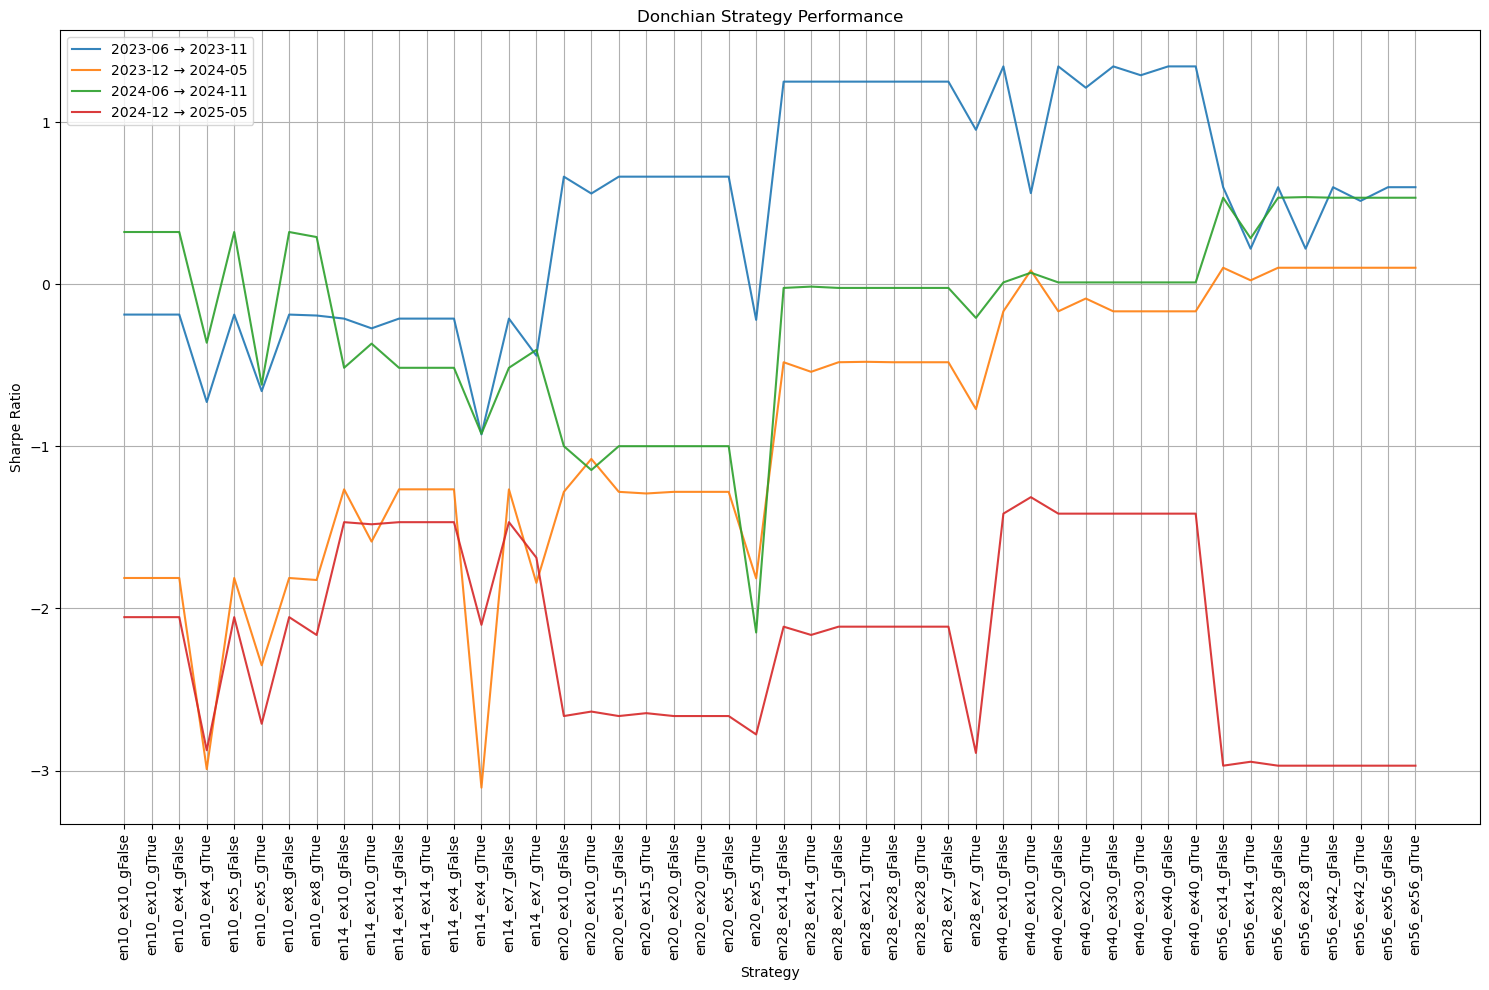

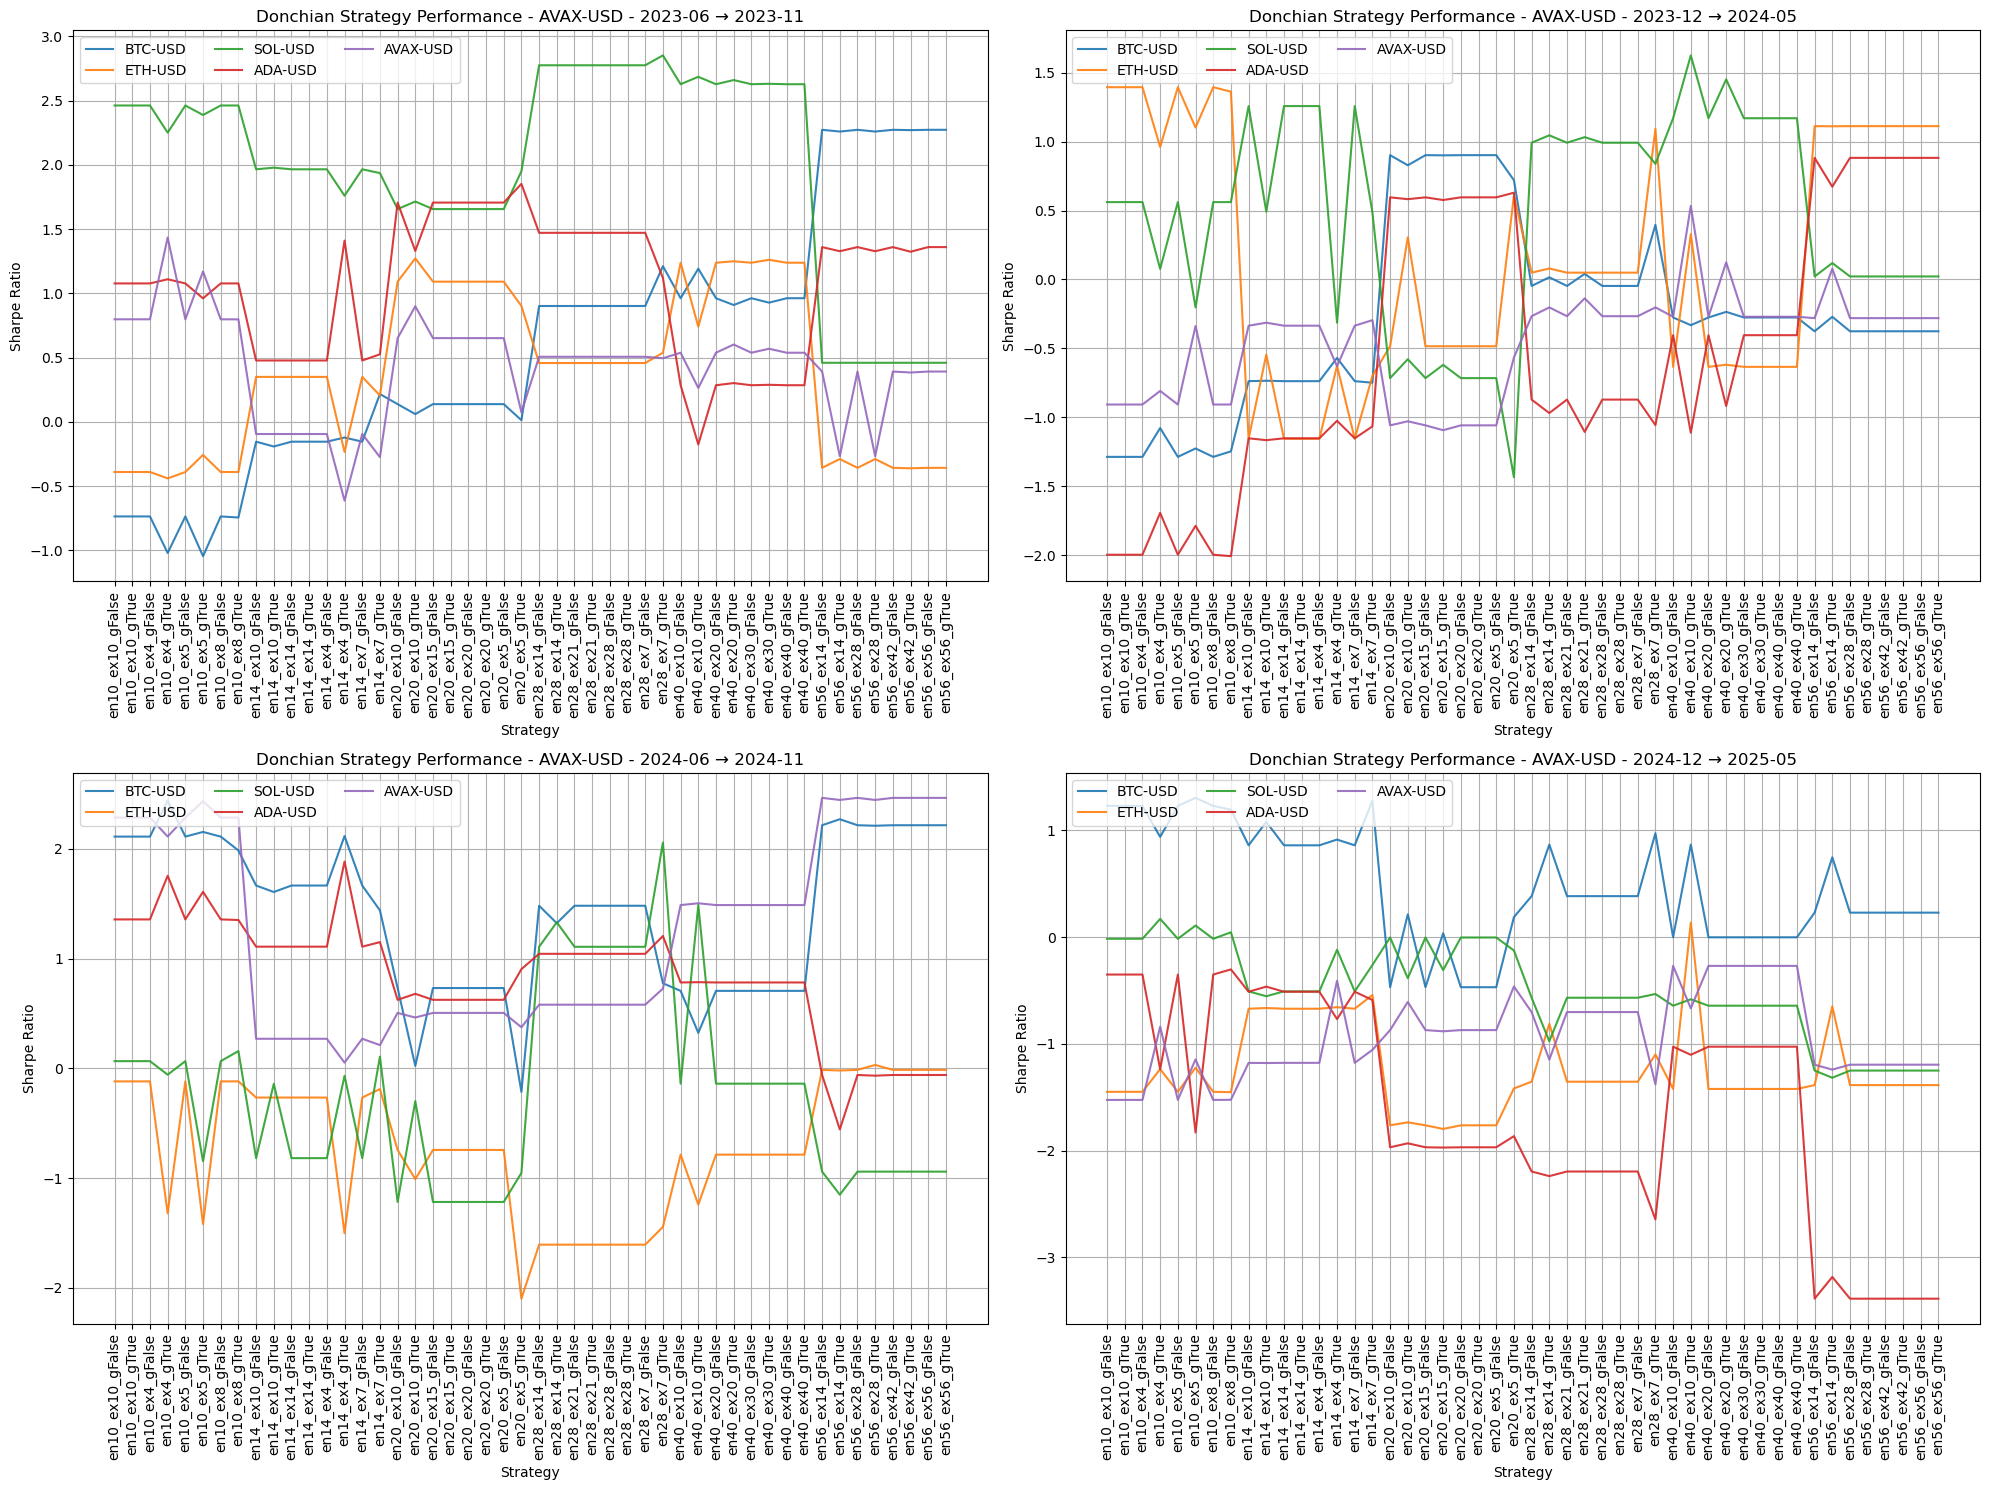

In [249]:
plot_donchian_channel_performance(df_donchian_results_os, ticker_list)

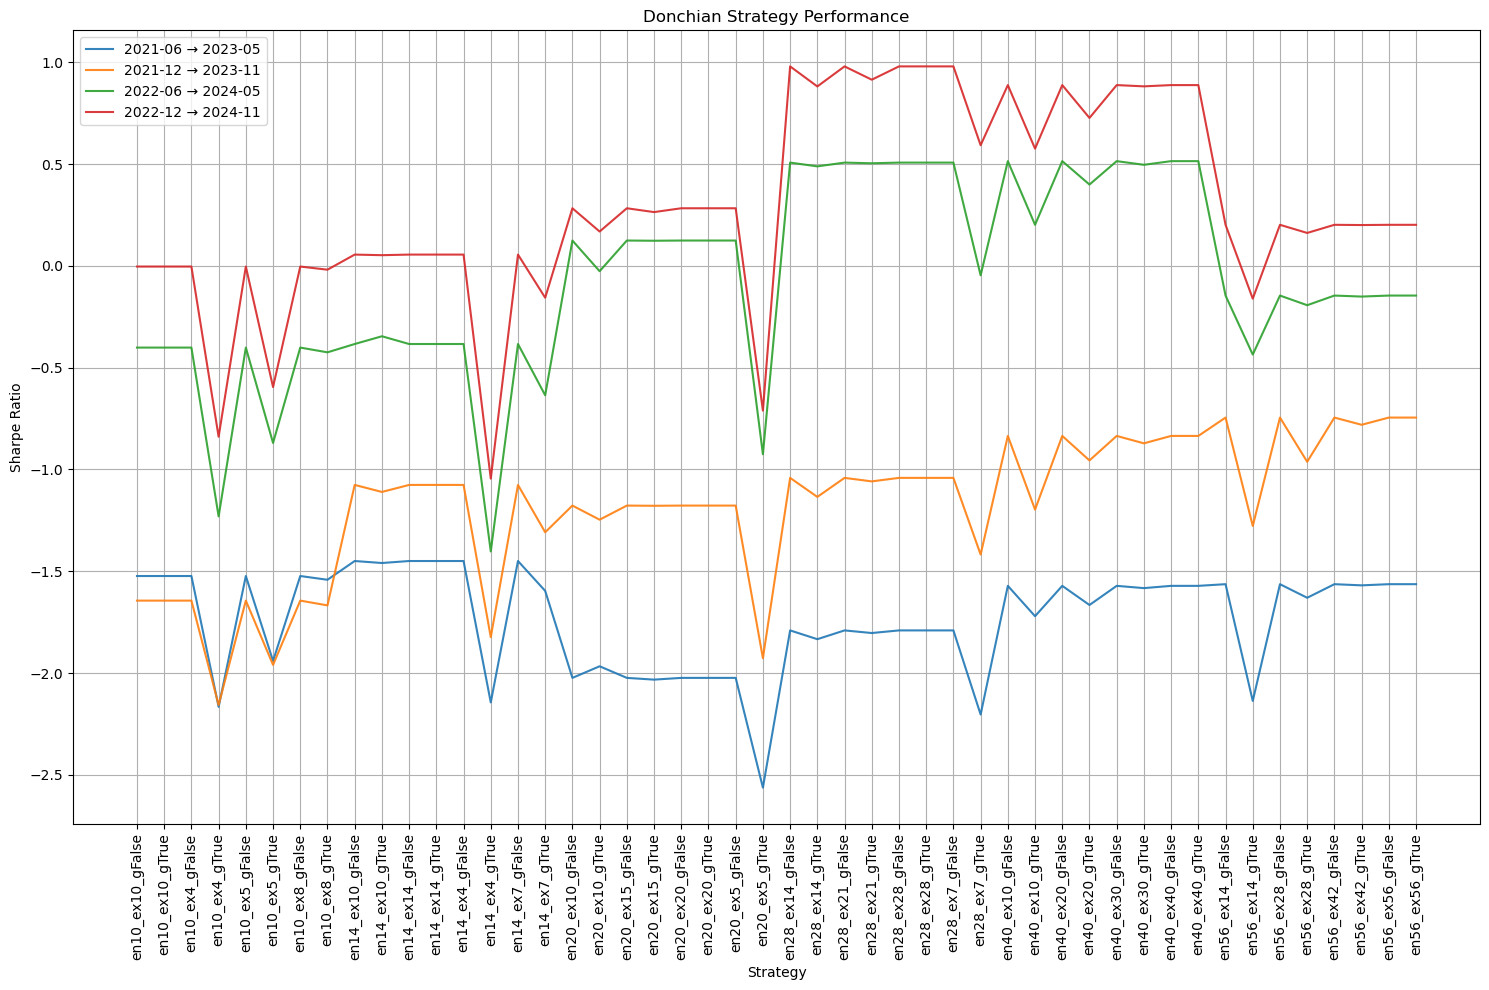

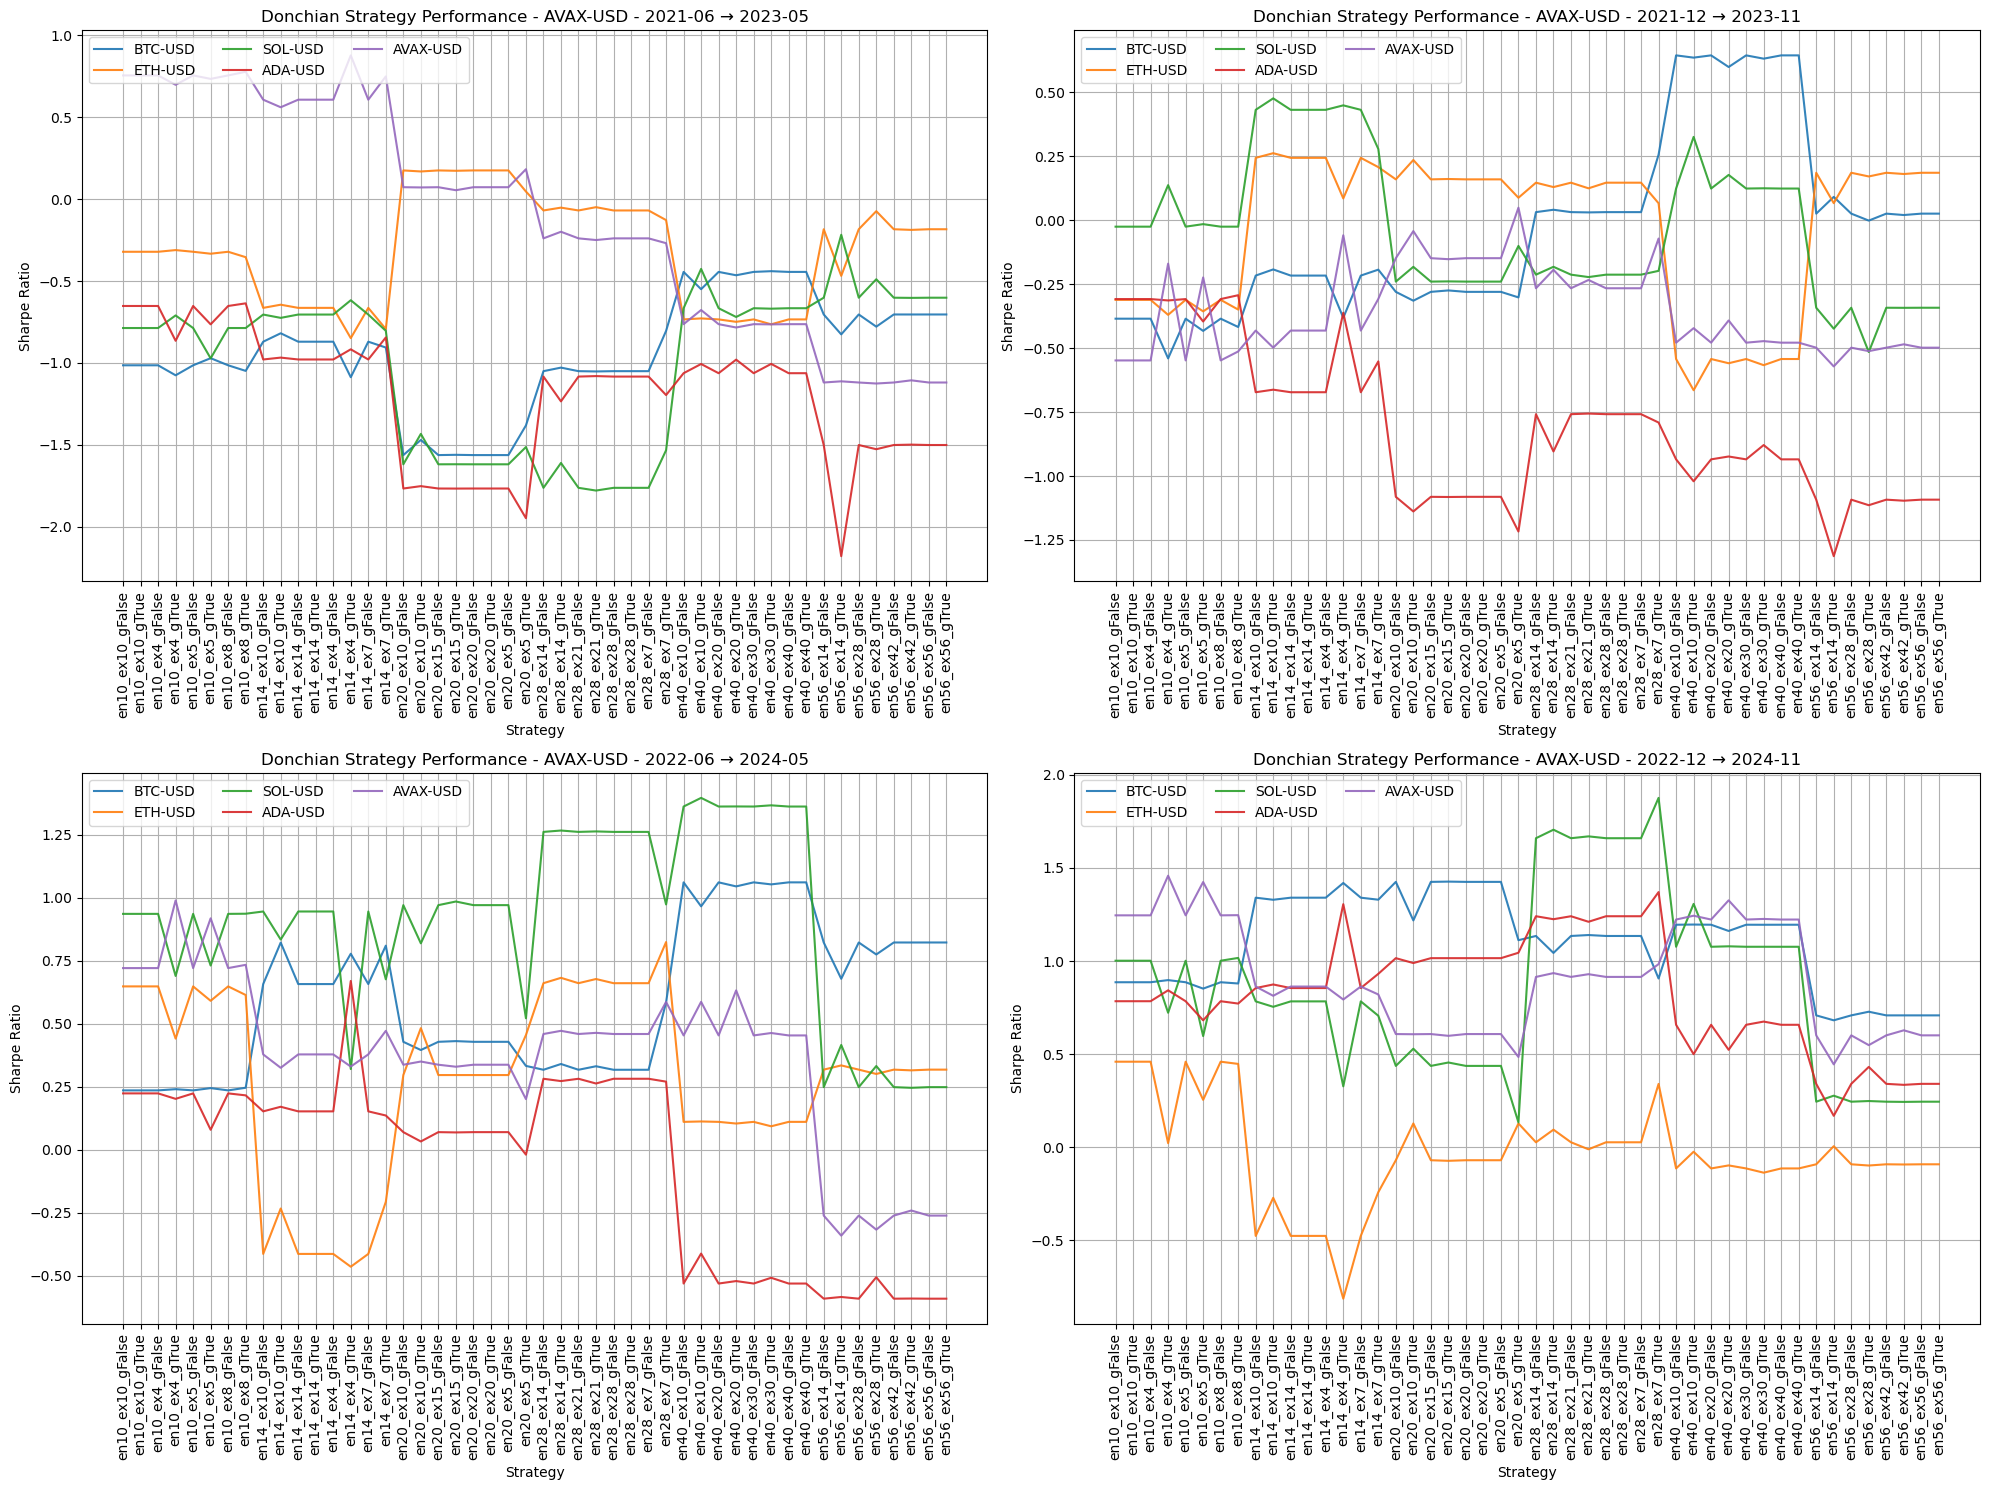

In [251]:
plot_donchian_channel_performance(df_donchian_results_is, ticker_list)

In [265]:
## Generate Trend Signal for all tickers
df_trend_ada_os = get_trend_donchian_signal_for_portfolio(start_date=pd.Timestamp('2024-12-01').date(), end_date=pd.Timestamp('2025-05-31').date(), ticker_list=['ADA-USD'], fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=40, 
                                                          exit_rolling_donchian_window=10, use_donchian_exit_gate=True,
                                                          donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [259]:
df_ada_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2024-12-01').date(), end_date=pd.Timestamp('2025-05-31').date(), ticker_list=['ADA-USD'], fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    entry_rolling_donchian_window=40, exit_rolling_donchian_window=10, 
    use_donchian_exit_gate=True, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [287]:
df_ada_os.groupby(['ADA-USD_event']).size()

ADA-USD_event
Add Long Position      11
Close Long Position     5
New Long Position       6
No Position            89
Open Long Position     41
Stop-Loss Cooldown      2
Trim Long Position      6
dtype: int64

In [285]:
df_ada_os.head(200)

,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_20,ADA-USD_cash_shrink_factor,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-22,0.118550,0.000000,0.000000,1.105951,0.0,0.8824,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.9047,0.000000,0.000000,0.0,0.000000,False,0.9047,-0.047484,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,1.000000,1.000000e+00,1.000000,1.0,0.000000,0.000000,NaN
2024-12-23,0.113574,0.000000,0.000000,1.078459,0.0,0.9252,0.0,No Position,NaN,NaN,0.882400,0.000000,0.000000,0.8824,0.000000,0.000000,0.0,0.000000,False,0.8824,-0.024649,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-24,0.110376,0.000000,0.000000,1.110829,0.0,0.9352,0.0,No Position,NaN,NaN,0.925100,0.000000,0.000000,0.9251,0.000000,0.000000,0.0,0.000000,False,0.9252,0.048504,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-25,0.105503,0.000000,0.000000,1.114251,0.0,0.9169,0.0,No Position,NaN,NaN,0.935100,0.000000,0.000000,0.9351,0.000000,0.000000,0.0,0.000000,False,0.9352,0.010808,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-26,0.099293,0.000000,0.000000,1.113562,0.0,0.8601,0.0,No Position,NaN,NaN,0.916900,0.000000,0.000000,0.9169,0.000000,0.000000,0.0,0.000000,False,0.9169,-0.019568,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-27,0.097208,0.000000,0.000000,1.089650,0.0,0.8758,0.0,No Position,NaN,NaN,0.860100,0.000000,0.000000,0.8601,0.000000,0.000000,0.0,0.000000,False,0.8601,-0.061948,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-28,0.093607,0.000000,0.000000,1.099505,0.0,0.8881,0.0,No Position,NaN,NaN,0.875800,0.000000,0.000000,0.8758,0.000000,0.000000,0.0,0.000000,False,0.8758,0.018254,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-29,0.087854,0.000000,0.000000,1.106230,0.0,0.8572,0.0,No Position,NaN,NaN,0.888000,0.000000,0.000000,0.8880,0.000000,0.000000,0.0,0.000000,False,0.8881,0.014044,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+12,0.000000,1.0,0.000000,0.000000,NaN
2024-12-30,0.085258,0.000000,0.000000,0.897542,0.0,0.8598,0.0,No Position,NaN,NaN,0.857300,0.000000,0.000000,0.8573,0.000000,0.000000,0.0,0.000000,False,0.8572,-0.034793,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,13500.000000,0.000000,1.000000e+1

In [269]:
df_trend_ada_os.head(200)

,ADA-USD_close,ADA-USD_open,ADA-USD_mavg_ribbon_slope,ADA-USD_mavg_ribbon_rank,ADA-USD_final_weighted_additive_signal,ADA-USD_final_signal
date,,,,,,
2024-12-01,1.1503,1.0796,NaN,NaN,NaN,NaN
2024-12-02,1.2024,1.1505,1.492622e-15,NaN,NaN,NaN
2024-12-03,1.1920,1.2028,1.867292e-03,NaN,NaN,NaN
2024-12-04,1.1887,1.1930,3.204300e-03,NaN,NaN,NaN
2024-12-05,1.1612,1.1886,4.303543e-03,NaN,NaN,NaN
2024-12-06,1.2292,1.1614,4.313666e-03,NaN,NaN,NaN
2024-12-07,1.2111,1.2298,6.714017e-03,NaN,NaN,NaN
2024-12-08,1.1946,1.2110,8.270222e-03,NaN,NaN,NaN
2024-12-09,1.0040,1.1944,9.099160e-03,NaN,NaN,NaN
